# Introduction-Data-Science Task 3

Lena Breitberg, Doreen Mack, David Riethmann

---

# Setup

## Imports

In [1]:
import itertools

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn._config import set_config
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from lazypredict.Supervised import LazyRegressor

import helpers
set_config(transform_output="pandas")
%matplotlib inline

### Load Data

In [2]:
test_data = pd.read_csv('../data/BikeRentalDaily_test.csv', sep=';', index_col='instant')
train_data = pd.read_csv('../data/BikeRentalDaily_train.csv', sep=';', index_col='instant')

### Load Data without Outlier

In [3]:
outlier_remover = helpers.OutlierRemover(target='cnt', threshold=3.0)

In [4]:
test_data_no = outlier_remover.fit_transform(test_data)
train_data_no = outlier_remover.fit_transform(train_data)

131 rows remaining after removing outliers.
596 rows remaining after removing outliers.


## Pipeline

Das sind die finalen Schritte des Preprocessing aus Taks 2.

In [5]:
datetime_converter = helpers.DatetimeConverter(target_column='dteday', date_format='%d.%m.%Y')
season_imputer = helpers.SeasonImputer(target_column='season', date_column='dteday')
correct_weekday = helpers.WeekdayMapper(target_column='weekday', date_column='dteday')
windspeed_mean_imputer = helpers.ThresholdImputer(target_column='windspeed', threshold=0.0)
column_name_transformer = FunctionTransformer(helpers.clean_column_names)
weekend_group = helpers.GroupOneHotEncodedTransformer(grouping_info={'weekend': ['weekday_0', 'weekday_6']})
weekday_group = helpers.GroupOneHotEncodedTransformer(grouping_info={'weekday': ['weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5']})

In [6]:
feature_transformer = make_column_transformer(
    (OneHotEncoder(sparse_output=False, dtype=int), ['season', 'weekday', 'weathersit']),
    (make_pipeline(SimpleImputer(strategy='mean'), StandardScaler()), ['hum']),
    (StandardScaler(), ['atemp', 'windspeed', 'leaflets']),
    ('drop', ['temp', 'workingday', 'mnth', 'dteday', 'cnt', 'casual', 'registered']),
    remainder='passthrough'
)

In [7]:
preprocessing_pipeline = make_pipeline(
    datetime_converter,
    season_imputer,
    correct_weekday,
    windspeed_mean_imputer,
    feature_transformer,
    column_name_transformer,
    weekend_group,
    weekday_group
)

## Split Data

In [8]:
X_train, X_validate, y_train, y_validate = train_test_split(train_data, train_data['cnt'], test_size=0.2, random_state=42)

In [9]:
X_train_no, X_validate_no, y_train_no, y_validate_no = train_test_split(train_data_no, train_data_no['cnt'], test_size=0.2, random_state=42)

## Performance Measures

In [10]:
def performance_measures(y_true, y_pred, n_predictors) -> tuple:
    """
    Calculate R2, Adjusted R2, and MAE
    
    Args:
        y_true: array-like, True values
        y_pred: array-like, Predicted values
        n_predictors: int, number of predictors used in the model excluding the intercept
        
    Returns:
        r2: float, R2 score
        adjusted_r2: float, Adjusted R2 score
        mae: float, Mean Absolute Error
    """
    n = len(y_true)  # Number of observations
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - n_predictors - 1))
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    
    measures = {
        "R2": r2,
        "Adjusted_R2": adjusted_r2,
        "MAE": mae,
        "RMSE": rmse
    }

    print(f"R2: {r2:.2f}")
    print(f"Adjusted R2: {adjusted_r2:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    
    return measures



In [11]:
def actualVsPredictChart(true_v, pred_v, model: str = ""):
    data = {"Actual": true_v, "Predicted": pred_v}
    df = pd.DataFrame(data)

    # Create a lineplot with Seaborn
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))

    sns.lineplot(data=df, markers=False)

    plt.title(f"{model} Actual vs. Predicted Values")
    plt.xlabel("Data Points")
    plt.ylabel("Values")

    plt.show()

# 1 Baseline Model

### Pipeline

In [12]:
baseline = make_pipeline(
    preprocessing_pipeline,
    LinearRegression()
)

### Evaluation

In [13]:
baseline.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('datetimeconverter',
                                  DatetimeConverter(date_format='%d.%m.%Y',
                                                    target_column='dteday')),
                                 ('seasonimputer',
                                  SeasonImputer(date_column='dteday',
                                                target_column='season')),
                                 ('weekdaymapper',
                                  WeekdayMapper(date_column='dteday',
                                                target_column='weekday')),
                                 ('thresholdimputer',
                                  ThresholdImputer(target_column='windspeed'))...
                                  FunctionTransformer(func=<function clean_column_names at 0x7fb2794a7100>)),
                                 ('grouponehotencodedtransformer-1',
                                  GroupOneHotEncodedTransformer(grouping_info={'weekend': ['weekday_0',
                                                                                           'weekday_6']})),
                                 ('grouponehotencodedtransformer-2',
                                  GroupOneHotEncodedTransformer(grouping_info={'weekday': ['weekday_1',
                                                                                           'weekday_2',
                                                                                           'weekday_3',
                                                                                           'weekday_4',
                                                                                           'weekday_5']}))])),
                ('linearregression', LinearRegression())])

In [14]:
y_pred = baseline.predict(X_validate)

In [15]:
measures = performance_measures(y_validate, y_pred, len(baseline.named_steps.linearregression.coef_))

R2: 0.22
Adjusted R2: 0.10
MAE: 1263.24
RMSE: 4160.60


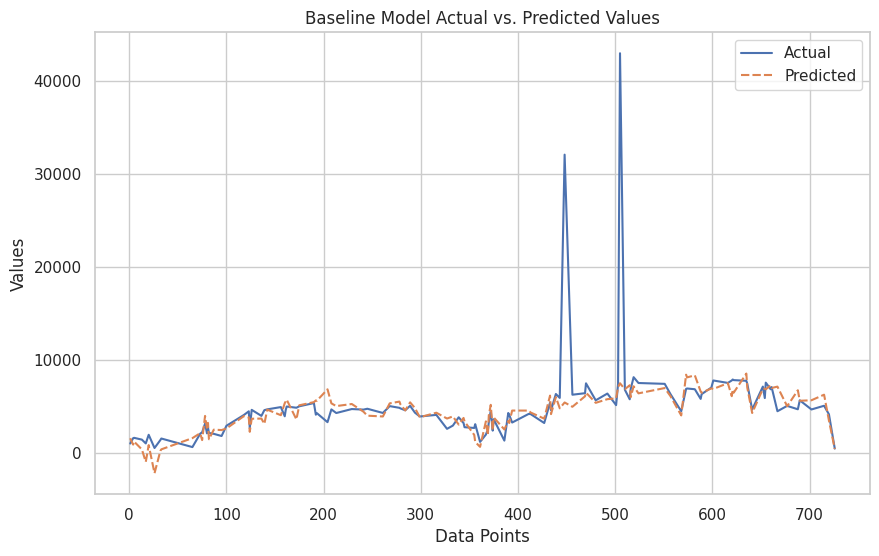

In [16]:
actualVsPredictChart(y_validate, y_pred, "Baseline Model")

# 2 Initial Model Selection

## Helpers

In [17]:
def visualize_lazy_predictions(models, predictions, y_validate, n_predictors: int):
    """
    Visualize the predictions from the lazy regressor

    Args:
        predictions: dict, predictions from the lazy regressor
    """
    models = models.sort_values(by='R-Squared', ascending=False)
    for model_name in models.iloc[: 3].index:
        y_pred = predictions[model_name].to_list()
        _ = performance_measures(y_validate, y_pred, n_predictors)
        actualVsPredictChart(y_validate, y_pred, model_name)

Für die Evaluierung verschiedener Algorithmen nutzen wir die Bibliothek Lazy Predict bzw. aus dieser Bibliothek den Lazy Regressor. Diese wurde von Shankar Rao Pandala entwickelt. Es handelt sich um eine Wrapper-Bibliothek, die auf vielen verschiedenen Machine Learning Bibliotheken und -Algorithmen basiert.
Der Lazy Regressor automatisiert den Auswahlprozess geeigneter Regressionsmodelle, indem eine Vielzahl von Modellen auf den vorliegenden Datensatz angewandt wird. Dieser wird zuvor durch minimales Preprocessing für den Auswahlprozess vorbereitet z.B. mittels Scaling und Imputation. 
Im Anschluss werden die Modelle anhand der gängigen Metriken, in unserem Fall R-Squared und MAE bewertet. Es ist wichtig zu beachten, dass kein automatisiertes Hyperparamter Tuning durchgeführt wird.
Dieses Vorgehen bietet vor allem den Vorteil, dass des gesamte Prozess automatisiert abläuft und die Bibliothek sehr einfach anzuwenden ist. Zusätzlich wird eine erhebliche Zeitersparnis ermöglicht.

## With Outlier

In [18]:
X_train = preprocessing_pipeline.fit_transform(X_train)
X_validate = preprocessing_pipeline.fit_transform(X_validate)

In [19]:
lazy_regressor = LazyRegressor(verbose=0, ignore_warnings=True, predictions=True)
models, predictions = lazy_regressor.fit(X_train, X_validate, y_train, y_validate)

100%|██████████| 42/42 [00:01<00:00, 22.41it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 661
[LightGBM] [Info] Number of data points in the train set: 480, number of used features: 14
[LightGBM] [Info] Start training from score 4632.100000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

In diesem DataFrame sind die Metriken der jeweiligen Modelltypen zu sehen. Zu erkennen ist, dass der Typ `GradientBoostingRegressor` nach allen Metriken den höchsten Wert für Adjusted R-Squared erzielt. Weitere gut abschneidende Modelltypen sind der `XGBRegressor` und der `ExtraTreesRegressor`. Für das Parametertuning werden alle drei Typen näher betrachtet, da es sein könnte, dass eines der drei Modelle deutlich besser abschneidet, sobald die Hyperparameter angepasst werden. Den Modelltyp `HistGradientBoostingRegressor` werden wir nicht verwenden, da dieser besonders ähnliche Eigenschaften aufweist, wie der `GradientBoostingRegressor`.

In [20]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
RANSACRegressor,0.14,0.25,4069.41,0.02
HuberRegressor,0.13,0.24,4093.27,0.01
PassiveAggressiveRegressor,0.13,0.24,4097.50,0.01
LGBMRegressor,0.12,0.24,4104.24,0.03
LassoLarsIC,0.11,0.23,4131.49,0.01
LassoLarsCV,0.11,0.23,4143.04,0.02
LarsCV,0.11,0.23,4143.04,0.05
LassoCV,0.10,0.23,4145.23,0.06
SGDRegressor,0.10,0.22,4149.64,0.01


Auf dieser Grafik ist ein Vergleich zwischen tatsächlichen und vorhergesagten Daten des `GradientBoostingRegressor` zu sehen. Es ist zu erkennen, dass es einige Ausreißer nach unten gibt, die das Modell nicht abbilden konnte. Bei dem Wert am rechten Ende des Graphen konnte das Modell dies jedoch sehr gut.

R2: 0.25
Adjusted R2: 0.14
MAE: 1081.16
RMSE: 4069.41


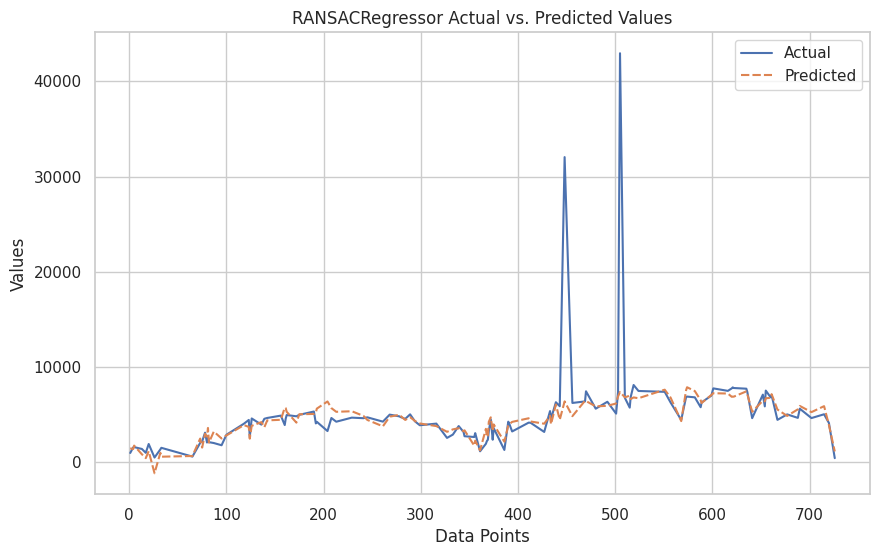

R2: 0.24
Adjusted R2: 0.13
MAE: 1087.04
RMSE: 4093.27


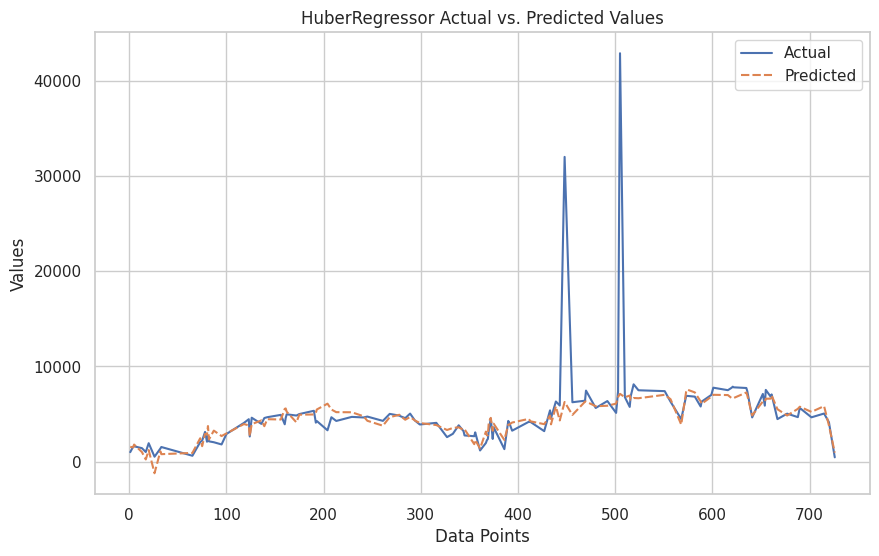

R2: 0.24
Adjusted R2: 0.13
MAE: 1090.16
RMSE: 4097.50


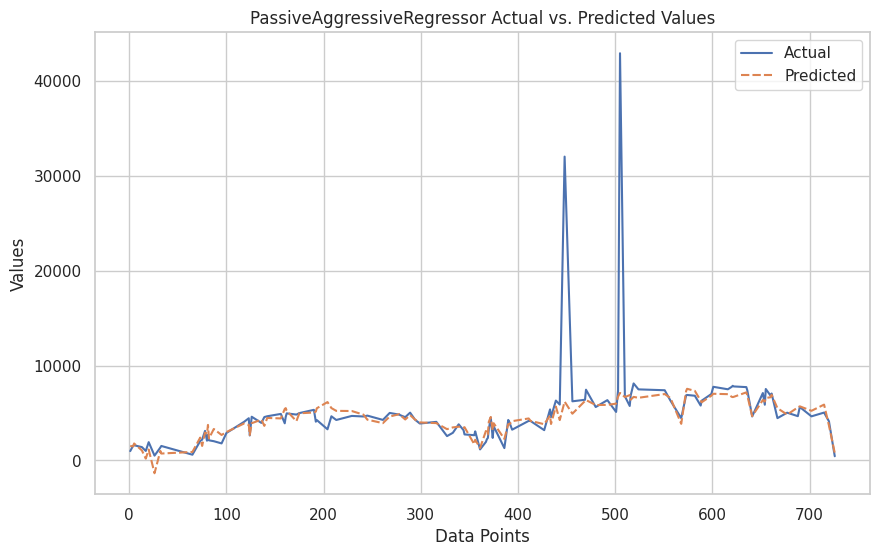

In [21]:
visualize_lazy_predictions(models, predictions, y_validate, X_train.shape[1])

## Without Outlier

In [22]:
X_train_no = preprocessing_pipeline.fit_transform(X_train_no)
X_validate_no = preprocessing_pipeline.fit_transform(X_validate_no)

In [23]:
lazy_regressor_no = LazyRegressor(verbose=0, ignore_warnings=True, predictions=True)
models_no, predictions_no = lazy_regressor_no.fit(X_train_no, X_validate_no, y_train_no, y_validate_no)

100%|██████████| 42/42 [00:01<00:00, 22.01it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 476, number of used features: 14
[LightGBM] [Info] Start training from score 4459.361345
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

In [24]:
models_no

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.86,0.88,653.88,0.18
PassiveAggressiveRegressor,0.84,0.86,694.38,0.01
HuberRegressor,0.84,0.86,699.40,0.01
RANSACRegressor,0.83,0.86,705.75,0.02
Lars,0.83,0.85,711.87,0.02
LarsCV,0.83,0.85,714.54,0.03
LassoLarsCV,0.83,0.85,714.54,0.01
LassoLarsIC,0.83,0.85,715.10,0.01
LassoLars,0.83,0.85,715.10,0.01


R2: 0.88
Adjusted R2: 0.86
MAE: 525.23
RMSE: 653.88


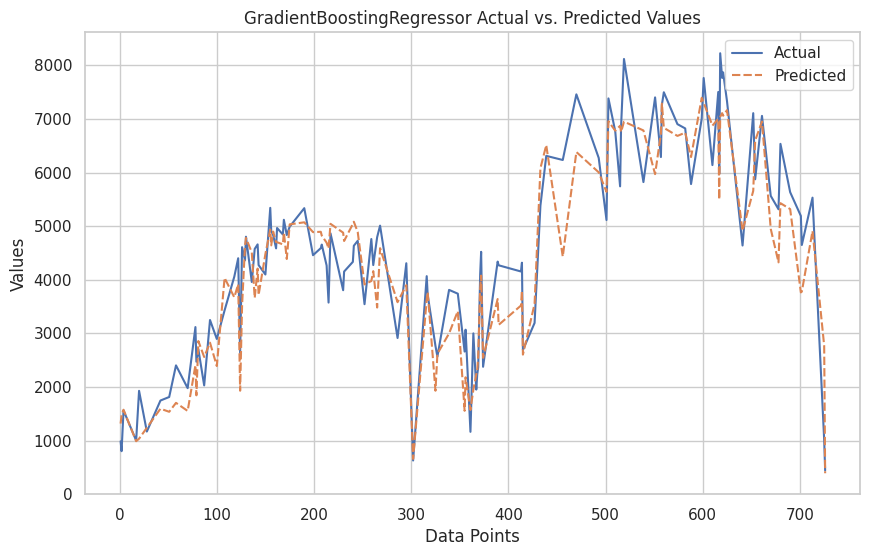

R2: 0.86
Adjusted R2: 0.84
MAE: 566.47
RMSE: 694.38


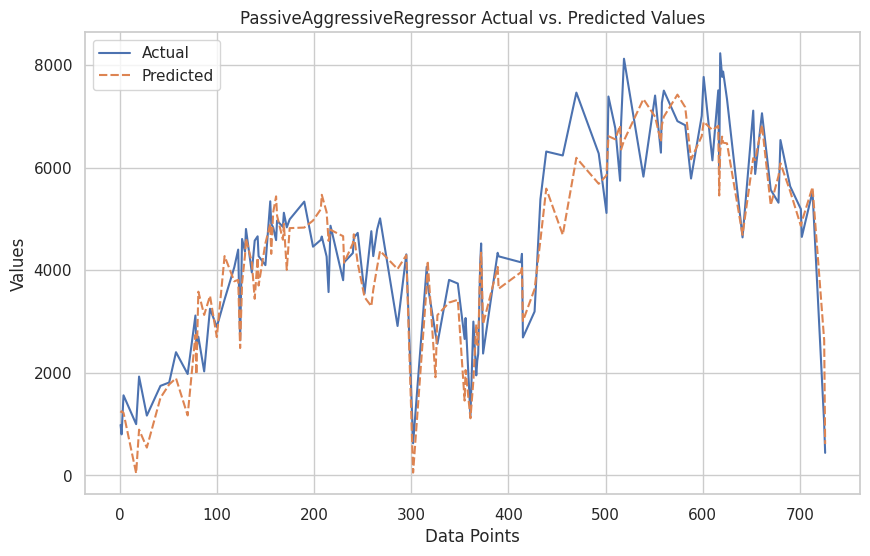

R2: 0.86
Adjusted R2: 0.84
MAE: 562.53
RMSE: 699.40


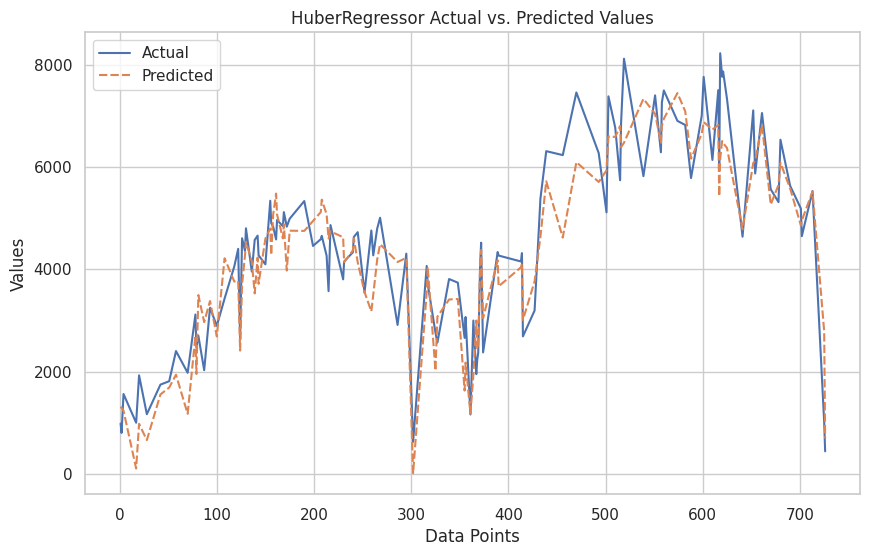

In [25]:
visualize_lazy_predictions(models_no, predictions_no, y_validate_no, X_train_no.shape[1])

# 3 Hyperparamter Tuning

Im Folgenden probieren wir verschiedene Kombinationen von Hyperparametern für die drei ausgewählten Algorithmen aus, um jeweils die beste Leistung des Modells zu erzielen.

### 3.1 GradientBoostingRegressor

- **Loss**: Loss bezeichnet das Verlustmaß. Dieses soll minimiert werden. Wir verwenden die Methode "quantile" d.h. die Quantilregression. Hierdurch wird der quantile Fehler minimiert, was zu robusteren Regressionen führen kann. Desweiteren stehen die Methoden squared_error (Minimierung des mittleren quadratischer Fehlers zwischen vorhergesagten und tatsächlichen Werten), absolute_error (Minimierung des mittleren absoluten Fehlers zwischen vorhergesagten und tatsächlichen Werten) sowie huber (Kombination aus quadratischem und absolutem Fehler) zur Auswahl.
- **Alpha**: Der Alpha-Wert beeinflusst die Gewichtung der Residuals in der Quantilregression. Durch die Variation von alpha kann der Fokus auf unterschiedliche Quantile gelegt werden. Wir verwenden eine Liste von Werten von 0.2 bis 0.8 in Schritten von 0.2.
- **Criterion**: Hiermit ist das Kriterium gemeint, das zur Auswahl der besten Aufteilung in jedem Entscheidungsbaumknoten verwendet wird. In diesem Fall werden 'friedman_mse' und 'squared_error' verwendet. 'friedman_mse' ist eine verbesserte Version des mittleren quadratischen Fehlers (MSE) für Gradient Boosting.
- **Learning Rate**: Die Lernrate steuert, wie stark jeder Baum die vorherigen Bäume korrigiert. Eine niedrige Lernrate erfordert im Normalfall mehr Bäume, um den gleichen Effekt zu erzielen, kann jedoch im Gegenzug zu einer besseren Generalisierung führen. Hier werden Werte von 0.1 bis 0.5 in Schritten von 0.1 verwendet.
- **Max Depth**: Max Depth meint die maximale Tiefe eines einzelnen Entscheidungsbaums. Eine tiefere Baumstruktur kann zu Overfitting führen, während eine flachere Struktur zu Underfitting führen kann. Wir verwenden hier die Werte None, 5 und 10. None bedeutet, dass es keine festgelegte maximale Tiefe gibt.
- **Number of Estimators**: Hier wird die Anzahl der Bäume (Schätzer) im Ensemble festgelegt. Eine höhere Anzahl von Bäumen kann zu einer besseren Modellleistung führen, erfordert jedoch mehr Rechenressourcen. Wir legen die Werte 50, 100 und 200 zur Auswahl fest.

### 3.2 PassiveAggressiveRegressor 

- **Loss**: Wie bei anderen Regressionsmodellen bezieht sich Loss auf das Maß für den Fehler zwischen den vorhergesagten und den tatsächlichen Werten. Der PassiveAggressiveRegressor unterstützt verschiedene Loss-Funktionen, darunter die Quantilregression (quantile), squared_error, absolute_error und huber, die eine Kombination aus quadratischem und absolutem Fehler darstellt.

- **C**: Dieser Parameter steuert die Stärke der Regularisierung. Eine höhere C-Wert bedeutet eine geringere Regularisierung, was dazu führen kann, dass das Modell stärker auf die Daten passt, aber auch anfälliger für Overfitting ist.

- **Epsilon**: Epsilon ist ein Toleranzparameter, der angibt, wie groß der Fehler sein kann, bevor eine Aktualisierung des Modells erfolgt. Ein kleinerer Epsilon-Wert führt zu einem schnelleren Lernen, während ein größerer Wert das Modell stabiler macht, aber möglicherweise länger braucht, um zu konvergieren.

- **Average**: Dieser Parameter steuert, wie die Gewichtungen der Instanzen über die Zeit gemittelt werden. Mögliche Optionen sind "True", was bedeutet, dass eine gleitende Durchschnittsbildung erfolgt, und "False", was bedeutet, dass keine Durchschnittsbildung erfolgt.

- **Max Iterations**: gibt die maximale Anzahl von Iterationen an, die das Modell durchlaufen soll, bevor es anhält. Es beeinflusst die Konvergenz des Modells und sollte angemessen groß gewählt werden, um sicherzustellen, dass das Modell ausreichend trainiert ist.

- **Tolerance**: Tolerance ist ein weiterer Parameter, der die Konvergenz des Modells steuert. Es gibt an, wie viel die Loss-Funktion sich ändern muss, bevor das Modell aufhört zu lernen.

- **Warm Start**: Wenn dieser Parameter auf "True" gesetzt ist, wird das Modell mit den Gewichten des vorherigen Aufrufs initialisiert. Das kann nützlich sein, um das Modell inkrementell zu trainieren.

- **Shuffle**: Shuffle steuert, ob die Daten vor jedem Schritt zufällig neu angeordnet werden. Das kann helfen, Overfitting zu vermeiden und sicherzustellen, dass das Modell besser generalisiert.

- **Random State**: Dieser Parameter ermöglicht die Reproduzierbarkeit der Ergebnisse, indem ein fester Zufallszahlengenerator verwendet wird.

### 3.3 HuberRegressor

- **Loss**: Es minimiert den Fehler durch Huber-Verlustfunktion, eine Kombination aus mittlerem quadratischen Fehler (MSE) für kleine Fehler und mittlerem absoluten Fehler für große Fehler..

- **Alpha**: Der Alpha-Wert steuert die Toleranz des Huber-Verlusts für Ausreißer. Ein kleinerer Alpha-Wert macht das Modell robuster gegenüber Ausreißern.

- **Fit Intercept**: Legt fest, ob ein Intercept (Bias) in die Modellanpassung einbezogen werden soll.

- **Max Iterations**: Die maximale Anzahl von Iterationen, die das Modell durchläuft, um zu konvergieren.

- **Epsilon**: Eine Toleranzschwelle für den Huber-Verlust, bei der zwischen linearen und quadratischen Fehlern gewechselt wird.

- **Warm Start**: Wenn auf 'True' gesetzt, wird das Modell mit den Gewichten des vorherigen Aufrufs initialisiert.

### 3.4 Auswahl der optimalen Hyperparamter

Im Folgenden werden alle Hyperparameter definiert. Die Listen enthalten die möglichen Werte eines jeden Parameters. Jedes Modell hat verschiedene Hyperarameter zur Auswahl, die bereits vorgestellt wurden.

In [ ]:
gbRegressor = {
    "loss": ['squared_error'],#, 'absolute_error', 'huber', 'quantile'],
    "alpha": [0.2*x for x in range(1, 5)],
    "criterion": ['friedman_mse', 'squared_error'],
    "learning_rate": [0.1*x for x in range(-2, 3)],
    "max_depth": [None, 5, 10],
    "n_estimators": [50, 100, 200]
}

xgbRegressor = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 5, 10],
    "max_leaves": [0, 5, 10, 20],
    "learning_rate": [0.2*x for x in range(1, 5)],
    "booster": ["gbtree", "gblinear", "dart"],
    "grow_policy": [0, 1],
    "gamma": [1e-3, 1e-1, 1],
    "reg_alpha": [1e-3, 1e-1, 1],
    "reg_lambda": [1e-3, 1e-1, 1],
    "metric": [mean_absolute_error]
}

etRegressor = {
    "n_estimators": [50, 100, 200],
    "criterion": ["squared_error", "absolute_error", "friedman_mse", "poisson"],
    "max_features": ["sqrt", "log2"],
    "max_depth": [None, 3, 5, 10]
}

features = {
    ske.GradientBoostingRegressor: gbRegressor,
    xgb.XGBRegressor: xgbRegressor,
    ske.ExtraTreesRegressor: etRegressor
}

Mit Hilfe von `GridSearchCV` wird ein Hyperparameter-Tuning für jedes Modell durchgeführt, um jeweils die beste Kombination von Hyperparametern zu finden. Hierbei verwenden wir den negativen Mean Absolute Error als Bewertungsmetrik. Eine automatische Kreuzvalidierung findet ebenfalls statt.

In [ ]:
model_select_results = pd.DataFrame(columns=["model", "params", "mae"])


for model_type in features:
    gs_model = sms.GridSearchCV(estimator=model_type(random_state=1),
                                param_grid=features[model_type],
                                n_jobs=-1,
                                scoring='neg_mean_absolute_error')

    gs_model.fit(train_data.drop(["cnt"], axis=1), train_data["cnt"])
    print(f"Model type {model_type.__name__}\nreached MAE of {gs_model.best_score_*-1}\n Params: {gs_model.best_params_}")
    model_select_results.loc[len(model_select_results)] = [type(gs_model.best_estimator_), gs_model.best_params_, gs_model.best_score_*-1]

model_select_results.sort_values("mae", ignore_index=True, inplace=True)

In [ ]:
model_select_results

??? Das Modell mit dem besten Ergebnis ist der `XGBRegressor`. Der MAE beträgt 670.95 für folgende Hyperparamter:

In [ ]:
model_select_results.at[1, "params"]

# 4 Feature Selection

Feature Selection wird mithilfe von RFECV durchgeführt. RFECV verwendet die Ergebnisse der Kreuzvalidierung, um den optimalen Merkmalsatz zu bestimmen. Dieser Satz beinhaltet die Merkmale, die am besten zur Vorhersage der Zielvariable geeignet sind, wobei gleichzeitig Overfitting vermieden wird.

RFECV nutzt die rekursive Merkmalseliminierung (RFE), um den Prozess zu initiieren. Hierbei werden alle verfügbaren Merkmale verwendet und das Modell iterativ trainiert, wobei nach jeder Iteration die unbedeutendsten Merkmale entfernt werden. Die verbleibenden Merkmale werden erneut bewertet, um ihre Relevanz für die Modellleistung zu überprüfen.

Zur Verbesserung der Zuverlässigkeit der Merkmalsauswahl wird RFECV zudem mit Kreuzvalidierung kombiniert. Der Datensatz wird dabei in verschiedene Teile unterteilt, wobei ein Teil zum Testen und die übrigen zum Trainieren des Modells verwendet werden. Dieser Prozess wird mehrmals wiederholt, um sicherzustellen, dass alle Datenpunkte sowohl im Trainings- als auch im Testset enthalten sind.

=> ab jetzt umschreiben!


In [ ]:
#feature_results.loc[:10000, :].to_csv("feature_results.csv")

Eigenschaften der besten Modelle, sortiert nach dem MAE. Jede Zeile in dem DataFrame ist das Ergebnis eines Modells mit einer einzigartigen Feature-Kombination.

In [ ]:
feature_results

Features des besten Modells, nach MAE gewertet

In [ ]:
feature_results.iat[0, 0]

Um die Koeffizienten den jeweiligen Features zuordnen zu können, erstellen wir dafür ein separates DataFrame. Die Koeffizienten sind deshalb wichtig, da sie aussagen, wie wichtig ein Feature für eine genaue Vorhersage ist. Da die Daten bereits skaliert sind, sind alle Werte im Bereich [-1;1] und es gibt keine Gewichtungsunterschiede zwischen den Features.

In [ ]:
reg_dicts = []

for idx, row in feature_results.iterrows():
    reg_dicts.append({key: value for key, value in zip(row["features"], row["coefs"])})
coef_df = pd.DataFrame(data=reg_dicts)

Durchschnittliche Koeffizienten der jeweiligen Features im `Ridge`-Regressionsmodell

Erkenntnisse:
- Die gefühlte Temperatur hat einen relativ hohen Einfluss auf die Kundenzahl
- An Feiertagen sind ca. 100 Kunden weniger unterwegs
- Werbeblätter haben einen negativen Einfluss (Vielleicht doch weglassen?)
- Eine Preisreduktion hat nur wenig Einfluss auf die Kundenzahl
- Im Winter gibt es weitaus weniger Kunden, sonst gibt es keinen signifikaten Unterschied zwischen den Jahreszeiten
- Die Wetterbedingungen haben eine entsprechende Auswirkung
- Von Montag bis Mittwoch gibt es täglich weniger Kunden als an anderen Wochentagen
- Je stärker die Windgeschwindigkeit, desto weniger Fahrräder werden gemietet
- An Werktagen sind ca. 130 Kunden mehr unterwegs, was darauf hindeutet, dass diese Kunden Arbeitspendler sind
- Im Flgejahr gibt täglich 1000 Kunden mehr, als im Erstjahr (Kundenzuwachs)

Koeffiziententabelle speichern

In [ ]:
#coef_df.describe().round(2).T.sort_index().to_csv("coefficients.csv")

# 5 Final Model

In [ ]:
def build_model(mtype, features, params):

    fin_model = mtype(random_state=1, **params)

    fin_model.fit(X_train, y_train)

    y_pred = fin_model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return [mtype.__name__, mae, r2, fin_model, params]

In [ ]:
fin_features = feature_results.iat[0, 0]

In [ ]:
fin_models = pd.DataFrame(columns=["modeltype", "mae", "r2", "model", "params"])
for idx, row in model_select_results.iterrows():
    fin_models.loc[len(fin_models)] = build_model(row["model"], fin_features, row["params"])

In [ ]:
fin_models

In [ ]:
fin_models.loc[1, "params"]

**Modelltyp**
- `sklearn.ensemble.GradientBoostingRegressor`

**Hyperparameter**
- Alpha: `0.2`
- Messkriterium: `friedman_mse`
- Lernrate: `0.1`
- Loss: `squared_error`
- Maximale Baumtiefe: `5`
- Anzahl Regressoren: `100`

**Verwendete Features**
- `yr`
- `mnth`
- `workingday`
- `atemp`
- `leaflets`
- `weekday_4`
- `weekday_5`
- `weekday_6`
- `season_1`
- `season_4`
- `weathersit_1`
- `weathersit_2`

In [ ]:
#pickle.dump(fin_models.at[1, "model"], open("../models/final_model_optimized.pkl"))